In [1]:
from instruction_reader import InstructionReader
from parse import parse_sexprs
import random

import tensorflow.compat.v1 as tf
import os
import pdb
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from tf_optimizer import TfOptimizer
from parse import parse_sexprs
from instruction_reader import InstructionReader

from util_graph_gen import *
from graph_generator import *


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
tf.disable_v2_behavior()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import argparse
import pdb

from builder import build
from util import DEFAULTS
import copy

In [2]:
# Parse arguments
parser = argparse.ArgumentParser(description='Arguments for building a model that satisfies a set of geometry constraints')

# General arguments
parser.add_argument('--problem', '-p', action='store', type=str, help='Name of the file defining the set of constraints')
parser.add_argument('--dir', '-d', action='store', type=str, help='Directory containing problem files.')
parser.add_argument('--regularize_points', action='store', dest='regularize_points', type=float, default=DEFAULTS["regularize_points"])
parser.add_argument('--make_distinct', action='store', dest='make_distinct', type=float, default=DEFAULTS["make_distinct"])
parser.add_argument('--distinct_prob', action='store', dest='distinct_prob', type=float, default=DEFAULTS["distinct_prob"])
parser.add_argument('--min_dist', action='store', dest='min_dist', type=float, default=DEFAULTS["min_dist"])
parser.add_argument('--ndg_loss', action='store', dest='ndg_loss', type=float, default=DEFAULTS["ndg_loss"])

parser.add_argument('--n_models', action='store', dest='n_models', type=int, default=DEFAULTS['n_models'])
parser.add_argument('--n_tries', action='store', dest='n_tries', type=int, default=DEFAULTS['n_tries'])
parser.add_argument('--n_inits', action='store', dest='n_inits', type=int, default=DEFAULTS['n_inits'])
parser.add_argument('--verbosity', action='store', dest='verbosity', type=int, default=DEFAULTS['verbosity'])
parser.add_argument('--enforce_goals', dest='enforce_goals', action='store_true')
parser.add_argument('--plot_freq', action='store', dest='plot_freq', type=int, default=DEFAULTS['plot_freq'])
parser.add_argument('--loss_freq', action='store', dest='loss_freq', type=int, default=DEFAULTS['loss_freq'])
parser.add_argument('--losses_freq', action='store', dest='losses_freq', type=int, default=DEFAULTS['losses_freq'])

parser.add_argument('--unnamed_objects', dest='unnamed_objects', action='store_true')
parser.add_argument('--no_unnamed_objects', dest='unnamed_objects', action='store_false')
parser.set_defaults(unnamed_objects=True)

# Tensorflow arguments
parser.add_argument('--learning_rate', action='store', dest='learning_rate', type=float, default=DEFAULTS["learning_rate"])
parser.add_argument('--decay_steps', action='store', dest='decay_steps', type=float, default=DEFAULTS["decay_steps"])
parser.add_argument('--decay_rate', action='store', dest='decay_rate', type=float, default=DEFAULTS["decay_rate"])
parser.add_argument('--n_iterations', action='store', dest='n_iterations', type=int, default=DEFAULTS["n_iterations"])
parser.add_argument('--eps', action='store', dest='eps', type=float, default=DEFAULTS["eps"])

parser.add_argument('--experiment', dest='experiment', action='store_true')

parser.add_argument("--f", type=str, default='abc.def'),

args = parser.parse_args()
args = vars(args)


In [3]:
args['enforce_goals'] = True

In [10]:
from importlib import reload

import util_graph_gen
reload(util_graph_gen)
from util_graph_gen import *

import graph_generator
reload(graph_generator)
from graph_generator import *

Processing instructions...:   0%|          | 0/1 [00:00<?, ?it/s]

Processing instructions...: 100%|██████████| 1/1 [00:00<00:00, 27.71it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3) acute-iso-tri (P2)


Found 1 models


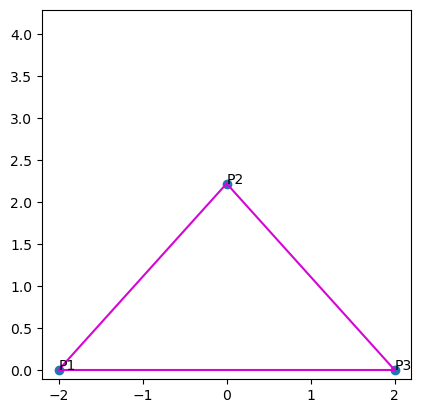

Processing instructions...:  67%|██████▋   | 2/3 [00:00<00:00, 15.86it/s]

######################## Lines drawn above ########################
['(param (P1 P2 P3) (acute-iso-tri P2) )']

INPUT INSTRUCTIONS:
sample (P1 P2 P3) acute-iso-tri (P2)
define C1 ((incircle P3 P2 P1))
define C2 ((excircle P1 P2 P3))


Processing instructions...: 100%|██████████| 3/3 [00:00<00:00, 11.85it/s]




Found 1 models


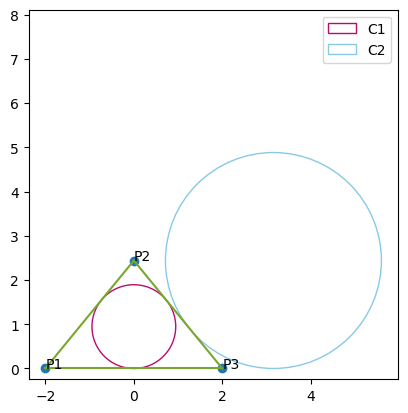

Processing instructions...:   0%|          | 0/6 [00:00<?, ?it/s]

######################## Lines drawn above ########################
['(param (P1 P2 P3) (acute-iso-tri P2) )', '(define C1 circle (incircle P3 P2 P1))', '(define C2 circle (excircle P1 P2 P3))']

INPUT INSTRUCTIONS:
sample (P1 P2 P3) acute-iso-tri (P2)
define C1 ((incircle P3 P2 P1))
define C2 ((excircle P1 P2 P3))
parameterize P4 (in-poly P1 P2 P3)
sample (P5 P6 P7) iso-tri (P6)
define L1 ((perp-bis P7 P4))


Processing instructions...:  33%|███▎      | 2/6 [00:00<00:00, 16.61it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3) acute-iso-tri (P2)
define C1 ((incircle P3 P2 P1))
define C2 ((excircle P1 P2 P3))
define P4 ((amidp-opp P2 P1 P3))
parameterize C3 (through-c P3)
sample (P5 P6 P7) acute-iso-tri (P5)


Processing instructions...:  33%|███▎      | 2/6 [00:00<00:00, 15.10it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3) acute-iso-tri (P2)
define C1 ((incircle P3 P2 P1))
define C2 ((excircle P1 P2 P3))
parameterize L1 line
parameterize L2 line
sample (P4 P5 P6) acute-tri ()


Processing instructions...:  33%|███▎      | 2/6 [00:00<00:00, 13.69it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3) acute-iso-tri (P2)
define C1 ((incircle P3 P2 P1))
define C2 ((excircle P1 P2 P3))
define C3 ((diam P1 P2))
parameterize C4 (through-c P2)
parameterize C5 circle


Processing instructions...: 100%|██████████| 6/6 [00:00<00:00, 16.96it/s]




Found 1 models


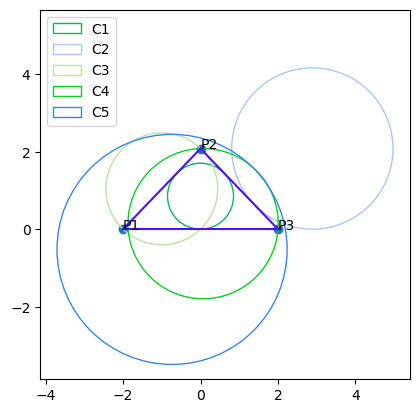

######################## Lines drawn above ########################
['(param (P1 P2 P3) (acute-iso-tri P2) )', '(define C1 circle (incircle P3 P2 P1))', '(define C2 circle (excircle P1 P2 P3))', '(define C3 circle (diam P1 P2))', '(param C4 circle (through P2))', '(param C5 circle )']



In [11]:
num_steps = 6
readers, figs = generate_graph(args, num_steps)

In [12]:
for item in readers:
    print(item)

    for pr_item in item.problem_lines:
        print(pr_item)
    print('')

(param (P1 P2 P3) (acute-iso-tri P2) )

(param (P1 P2 P3) (acute-iso-tri P2) )
(define C1 circle (incircle P3 P2 P1))
(define C2 circle (excircle P1 P2 P3))
(param P4 point (in-poly P1 P2 P3))
(param (P5 P6 P7) (iso-tri P6) )
(define L1 line (perp-bis P7 P4))

(param (P1 P2 P3) (acute-iso-tri P2) )
(define C1 circle (incircle P3 P2 P1))
(define C2 circle (excircle P1 P2 P3))
(define C3 circle (diam P1 P2))
(param C4 circle (through P2))
(param C5 circle )



Processing instructions...:   0%|          | 0/6 [00:00<?, ?it/s]

INPUT INSTRUCTIONS:
sample (P1 P2 P3) acute-iso-tri (P2)
define C1 ((incircle P3 P2 P1))
define C2 ((excircle P1 P2 P3))
define C3 ((diam P1 P2))
parameterize C4 (through-c P2)
parameterize C5 circle


Processing instructions...: 100%|██████████| 6/6 [00:00<00:00, 11.49it/s]




Found 1 models


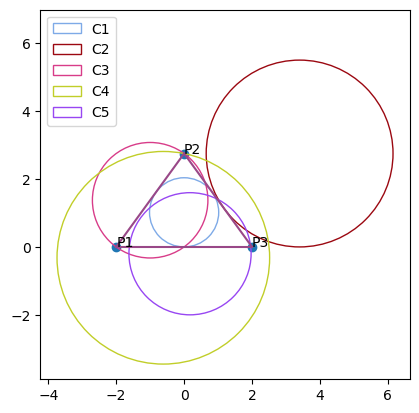

In [13]:
#lines = ['(param (P1 P2 P3) (right-tri P1) )']
lines = readers[-1].problem_lines

reader = InstructionReader(lines)
fig = solve_draw(args, reader)